In [1]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse
import random

from collections import Counter

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs

In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# Shapes

In [271]:
from skimage.draw import disk, rectangle, polygon

def generate_shape(shape, std=0.1, size=10):
    img = np.zeros((size, size), dtype=np.float32)
    center1 = np.round(size // 2 + np.random.uniform(0,0)).astype(np.int16)
    center2 = np.round(size // 2 + np.random.uniform(0,0)).astype(np.int16)
    
    if shape == 'circle':
        rr, cc = disk((center1, center2), radius=size//4, shape=img.shape)
        img[rr, cc] = 1
    elif shape == 'square':
        s = size // 3
        rr, cc = rectangle((center1-s, center2-s), extent=(2*s, 2*s), shape=img.shape)
        img[rr, cc] = 1
    elif shape == 'triangle':
        s = size // 3
        points = [(center1, center2 - s), (center1 - s, center2 + s), (center1 + s, center2 + s)]
        rr, cc = polygon([p[0] for p in points], [p[1] for p in points], shape=img.shape)
        img[rr, cc] = 1
    elif shape == 'plus':
        t = 1
        img[center1 - t:center1 + t + 1, :] = 1
        img[:, center2 - t:center2 + t + 1] = 1
    elif shape == "bar" :
        t = 1
        img[:, center1 - t:center2 + t + 1] = 1
    else:
        raise ValueError("Unknown shape")
    
    return img+  np.random.normal(0, std, size=img.shape)

In [257]:
shapes = ['square','triangle','plus']

X = []
y = []

for idx,shape in enumerate(shapes):
    for _ in range(250):
        X.append(generate_shape(shape, std=0, size=9))
        y.append(idx)

In [258]:
X = np.array(X).reshape(len(X), -1)
y = np.array(y)

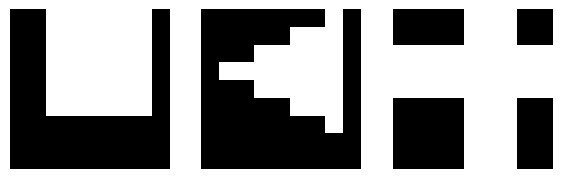

In [270]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 1, 3
for k in range(3):
    img = X[(k+1) * 249].reshape(9,9)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")

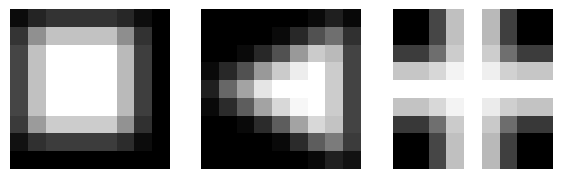

In [263]:
means = []
for k in range(3):
    indices = y == k
    means.append(np.mean(X[indices],axis=0))

figure = plt.figure(figsize=(7, 3.5))
rows, cols= 1, 3
for k in range(3):
    img = means[k].reshape(9,9)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")

In [260]:
def paint_mnist(X):
    figure = plt.figure(figsize=(7, 3.5))
    rows, cols= 5, 5
    for k in range(25):
        img = X[k,:].reshape(9,9)
        figure.add_subplot(rows, cols, k+1)
        plt.imshow(img, cmap="gray")
    plt.show()

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [125]:
X_train_bin = X_train > 0.5
X_test_bin = X_test > 0.5

In [228]:
pipeline = Pipeline([
    ('scaler', Normalizer())
])

X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

In [ ]:
name="shapes"

np.save(f"./../Datasets/Bernoulli/Processed/{name}/X_train_{name}.npy", X_train)
np.save(f"./../Datasets/Bernoulli/Processed/{name}/X_test_{name}.npy", X_test)
np.save(f"./../Datasets/Bernoulli/Processed/{name}/y_train_{name}.npy", y_train)
np.save(f"./../Datasets/Bernoulli/Processed/{name}/y_test_{name}.npy", y_test)

# Shapes Improved

In [ ]:
from skimage.draw import disk, rectangle, polygon

def generate_shape(shape, size=10, fg=0.95, bg=0.05):
    img = np.full((size, size), bg, dtype=np.float32)
    center1 = size // 2
    center2 = size // 2
    
    if shape == 'circle':
        rr, cc = disk((center1, center2), radius=size//4, shape=img.shape)
        img[rr, cc] = fg
    elif shape == 'square':
        s = size // 3
        r0, r1 = center1 - s, center1 + s
        c0, c1 = center2 - s, center2 + s
        img[r0:r1, c0:c1] = fg
    elif shape == 'triangle':
        s = size // 3
        points = [(center1, center2 - s), (center1 - s, center2 + s), (center1 + s, center2 + s)]
        rr, cc = polygon([p[0] for p in points], [p[1] for p in points], shape=img.shape)
        img[rr, cc] = fg
    elif shape == 'plus':
        t = 1
        img[center1 - t:center1 + t + 1, :] = fg
        img[:, center2 - t:center2 + t + 1] = fg
    elif shape == "bar" :
        t = 1
        img[:, center1 - t:center2 + t + 1] = fg
    else:
        raise ValueError("Unknown shape")
    
    return img
    

def make_bernoulli_patterns(N=1500, seed=0, d=10):
    rng = np.random.default_rng(seed)
    cluster_patterns = [
        generate_shape('triangle', size=d).flatten(),
        generate_shape('square', size=d).flatten(),
        generate_shape('plus', size=d).flatten()
    ]
    K =3

    pis = np.random.dirichlet(np.full(K, 1))

    X = []
    z = []

    for i in range(N):
        k = rng.choice(K, p=pis)
        x = rng.binomial(1, cluster_patterns[k])
        X.append(x)
        z.append(k)

    return np.array(X), np.array(z), pis

In [538]:
X, z, pis = make_bernoulli_patterns()

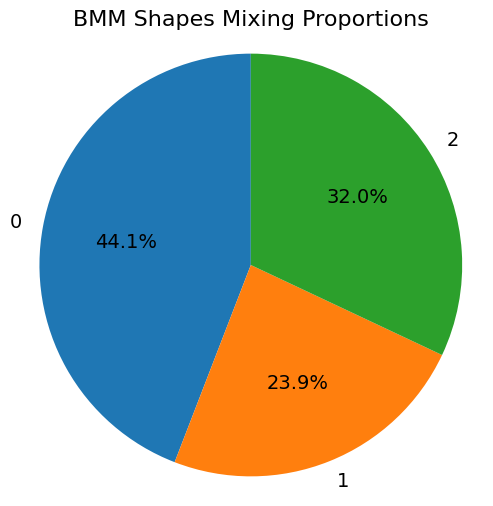

In [539]:
unique, counts = np.unique(z, return_counts=True)

plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=unique,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14}  # <-- Set label font size here
)
plt.title('BMM Shapes Mixing Proportions', fontsize=16)  # Optional: increase title size
plt.axis('equal')
plt.show()

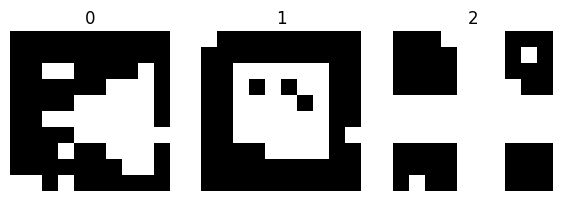

In [ ]:
# ones = X[z==0][0]
# twos = X[z==1][0]
# threes = X[z==2][0]

# shapes = [ones,twos,threes]

# # shapes = [
# #     generate_shape('triangle'),
# #     generate_shape('square'),
# #     generate_shape('plus')
# # ]

# figure = plt.figure(figsize=(7, 7))
# rows, cols= 1,3 
# for k in range(3):
#     img = shapes[k].reshape(10,10)
#     figure.add_subplot(rows, cols, k+1)
#     plt.title(k)
#     plt.axis("off")
#     plt.imshow(img, cmap="gray")
# plt.show()

In [440]:
means = []
for k in range(3):
    indices = z == k
    means.append(np.mean(X[indices], axis=0))
means = np.array(means)

In [441]:
def paint(X):
    figure = plt.figure(figsize=(7, 7))
    rows, cols= 1,3 
    for k in range(3):
        img = X[k,:].reshape(10,10)
        figure.add_subplot(rows, cols, k+1)
        plt.title(k)
        plt.axis("off")
        plt.imshow(img, cmap="gray")
    plt.show()

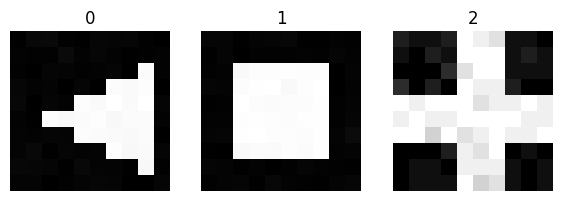

In [442]:
paint(means)

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, stratify=z, random_state=42)

In [ ]:
# name = "shapes"

# np.save(f"./../Datasets/Bernoulli/Processed/{name}/X_train_{name}.npy",X_train)
# np.save(f"./../Datasets/Bernoulli/Processed/{name}/X_test_{name}.npy",X_test)
# np.save(f"./../Datasets/Bernoulli/Processed/{name}/y_train_{name}.npy",y_train)
# np.save(f"./../Datasets/Bernoulli/Processed/{name}/y_test_{name}.npy",y_test)
# np.save(f"./../Datasets/Bernoulli/Processed/{name}/means_{name}.npy", np.array(means))
# np.save(f"./../Datasets/Bernoulli/Processed/{name}/pis_{name}.npy", pis)

# GMM Synthetic

In [25]:
from scipy.stats import wishart, multivariate_normal

In [ ]:
def generate_wishart_covariances(K, D, df=None, rng=None):
    rng = rng or np.random.default_rng()
    df = df or D + 2  # degrees of freedom must be >= D

    covs = []
    for _ in range(K):
        scale_matrix = np.eye(D)
        cov = wishart(df=df, scale=scale_matrix, seed=rng).rvs()
        covs.append(cov)

    return np.array(covs)

def generate_means(covariances):
    K,D,D = covariances.shape
    rng = np.random.default_rng()

    m_0 = np.zeros((D))
    k = 0.01

    means = []

    for cov in covariances:
        mean = rng.multivariate_normal(m_0, cov/k)
        means.append(mean)

    return np.array(means)

def generate_gmm_mixture_data(means, covariances, num_total):
    K,D = means.shape

    pis = np.random.dirichlet(np.full(K,1))
    n_samples_per_cluster = rng.multinomial(num_total, pis)

    X = []
    y = []

    for k in range(K):
        n_k = n_samples_per_cluster[k]
        X_k = np.random.multivariate_normal(means[k], covariances[k], size=n_k)
        y_k = np.full(n_k, k)

        X.append(X_k)
        y.append(y_k)

    return np.vstack(X), np.concatenate(y)

In [540]:
covariances = generate_wishart_covariances(3, 3)
means = generate_means(covariances)
X,y = generate_gmm_mixture_data(means, covariances, 750)

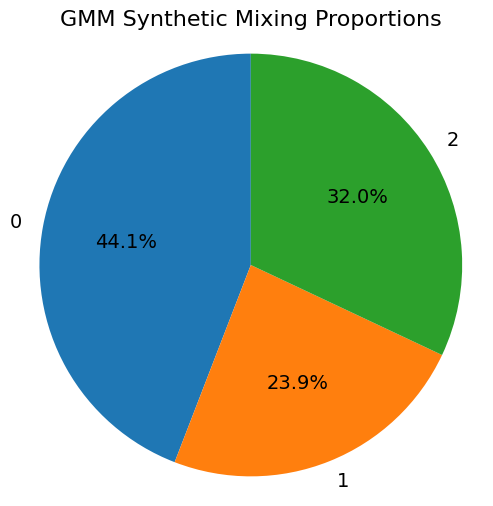

In [542]:
unique, counts = np.unique(z, return_counts=True)

plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=unique,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14}  # <-- Set label font size here
)
plt.title('GMM Synthetic Mixing Proportions', fontsize=16)  # Optional: increase title size
plt.axis('equal')
plt.show()

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [39]:
name = "synthetic"

np.save(f"./../Datasets/Gaussian/Processed/{name}/X_train_{name}.npy",X_train)
np.save(f"./../Datasets/Gaussian/Processed/{name}/X_test_{name}.npy",X_test)
np.save(f"./../Datasets/Gaussian/Processed/{name}/y_train_{name}.npy",y_train)
np.save(f"./../Datasets/Gaussian/Processed/{name}/y_test_{name}.npy",y_test)
np.save(f"./../Datasets/Gaussian/Processed/{name}/means_{name}.npy", np.array(means))
np.save(f"./../Datasets/Gaussian/Processed/{name}/covs_{name}.npy", np.array(covariances))

# Synthetic Bernoulli

## Synthetic Bernoulli 5

In [ ]:
def generate_bernoulli_parameters(K, D, a=1, b=1, rng=None):
    """
    Sample K D-dimensional Bernoulli probability vectors from Beta(a, b)
    """
    rng = rng or np.random.default_rng()
    return rng.beta(a, b, size=(K, D))

def generate_bernoulli_mixture_data(θ, num_total=2500, rng=None):
    rng = rng or np.random.default_rng()
    K, D = θ.shape

    pis = rng.dirichlet(np.full(K, 1))  # Equal prior

    n_samples_per_cluster = rng.multinomial(num_total, pis)

    X = []
    y = []

    for k in range(K):
        n_k = n_samples_per_cluster[k]
        samples = rng.binomial(n=1, p=θ[k], size=(n_k, D))
        labels = np.full(n_k, k)
        X.append(samples)
        y.append(labels)

    X = np.vstack(X)  # shape (num_total, D)
    y = np.concatenate(y)  # shape (num_total,)
    return X, y



In [552]:
thetas = generate_bernoulli_parameters(5, 5)
X,y = generate_bernoulli_mixture_data(thetas)

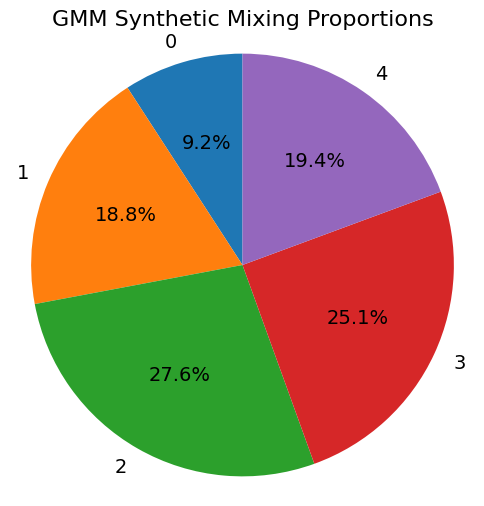

In [553]:
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=unique,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14}  # <-- Set label font size here
)
plt.title('GMM Synthetic Mixing Proportions', fontsize=16)  # Optional: increase title size
plt.axis('equal')
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
name="synthetic5"

np.save(f"./../Datasets/Bernoulli/Processed/{name}/X_train_{name}.npy", X_train)
np.save(f"./../Datasets/Bernoulli/Processed/{name}/X_test_{name}.npy", X_test)
np.save(f"./../Datasets/Bernoulli/Processed/{name}/y_train_{name}.npy", y_train)
np.save(f"./../Datasets/Bernoulli/Processed/{name}/y_test_{name}.npy", y_test)
np.save(f"./../Datasets/Bernoulli/Processed/{name}/means_{name}.npy", np.array(thetas))

# Guassian Digits 7 x 5

In [2]:
zero = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0],
])

one = np.array([
    [0,0,1,0,0],
    [0,1,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
])

two = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,0,0,1,0],
    [0,0,1,0,0],
    [0,1,0,0,0],
    [1,1,1,1,1],
])

three = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [0,0,0,0,1],
    [0,0,1,1,0],
    [0,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0],
])

four = np.array([
    [0,1,0,1,0],
    [0,1,0,1,0],
    [1,0,0,1,0],
    [1,1,1,1,1],
    [0,0,0,1,0],
    [0,0,0,1,0],
    [0,0,0,1,0],
])

five = np.array([
    [1,1,1,1,1],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,1,1,1,0],
    [0,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0],
])

six = np.array([
    [0,1,1,1,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0],
])

seven = np.array([
    [1,1,1,1,1],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,0,0,1,0],
    [0,0,1,0,0],
    [0,1,0,0,0],
    [1,0,0,0,0],
])

eight = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0],
])

nine = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,1],
    [0,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0],
])

templates = np.array([zero, one, two, three, four , five, six, seven ,eight, nine])

In [3]:
def paint_mnist(X):
    figure = plt.figure(figsize=(7, 3.5))
    rows, cols= 2, 5
    for k in range(10):
        img = X[k]
        figure.add_subplot(rows, cols, k+1)
        plt.imshow(img, cmap="gray")
    plt.show()

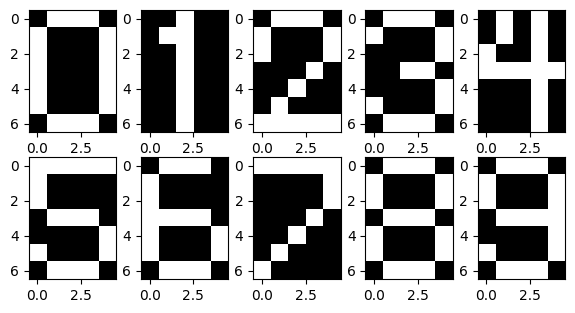

In [4]:
paint_mnist(templates)

In [40]:
def add_gaussian_noise(X, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=X.shape)
    X_noisy = X + noise
    return X_noisy

In [6]:
X = []
y = []

for i in range(10):
    for n in range(500):
        X.append(add_gaussian_noise(templates[i].flatten()))
        y.append(i)

X = np.array(X)
y = np.array(y)

In [7]:
means = []
covs = []
for k in range(10):
    means.append(np.mean(X[y==k], axis=0))
    covs.append(np.cov(X[y==k], rowvar=False))
means = np.array(means)
covs = np.array(covs)

In [49]:
def paint_mnist(X,D1,D2):
    figure = plt.figure(figsize=(7, 3.5))
    rows, cols= 2, 5
    for k in range(10):
        img = X[k,:].reshape(D1,D2)
        figure.add_subplot(rows, cols, k+1)
        plt.imshow(img, cmap="gray")
    plt.show()

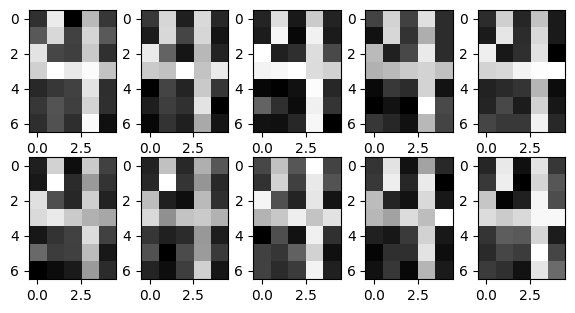

In [ ]:
paint_mnist(X[2000:], 5, 7)

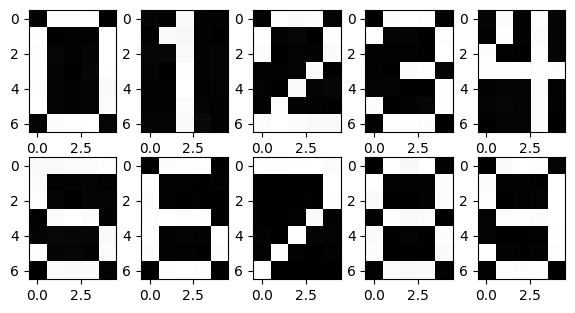

In [10]:
paint_mnist(means)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
name = "digits"

np.save(f"./../Datasets/Gaussian/Processed/{name}/X_train_{name}.npy", X_train)
np.save(f"./../Datasets/Gaussian/Processed/{name}/X_test_{name}.npy", X_test)
np.save(f"./../Datasets/Gaussian/Processed/{name}/y_train_{name}.npy", y_train)
np.save(f"./../Datasets/Gaussian/Processed/{name}/y_test_{name}.npy", y_test)
np.save(f"./../Datasets/Gaussian/Processed/{name}/means_{name}.npy", means)
np.save(f"./../Datasets/Gaussian/Processed/{name}/covariances_{name}.npy", covs)

# Digits Small 5x5

In [455]:
zero = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0]
])

one = np.array([
    [0,0,1,0,0],
    [0,1,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,1,1,1,0],
])

two = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [0,0,1,1,0],
    [0,1,0,0,0],
    [1,1,1,1,1],
])

three = np.array([
    [1,1,1,1,0],
    [0,0,0,0,1],
    [0,0,1,1,0],
    [0,0,0,0,1],
    [1,1,1,1,0]
])

four = np.array([
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,1],
    [0,0,0,0,1],
    [0,0,0,0,1]
])

five = np.array([
    [1,1,1,1,1],
    [1,0,0,0,0],
    [0,1,1,1,0],
    [0,0,0,0,1],
    [1,1,1,1,1]
])

six = np.array([
    [0,1,1,1,1],
    [1,0,0,0,0],
    [1,1,1,1,0],
    [1,0,0,0,1],
    [0,1,1,1,0]
])

seven = np.array([
    [1,1,1,1,1],
    [0,0,0,0,1],
    [0,0,0,1,0],
    [0,0,1,0,0],
    [0,1,0,0,0],
])

eight = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [0,1,1,1,0],
    [1,0,0,0,1],
    [0,1,1,1,0],
])


nine = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [0,1,1,1,1],
    [0,0,0,0,1],
    [0,0,0,0,1],
])


# digits = np.array([
#     zero, one, two, three, four, five, six, seven ,eight, nine
# ])

digits = np.array([
    zero, one, two, three, four
])

In [483]:
def paint_mnist(X):
    figure = plt.figure(figsize=(7, 3.5))
    rows, cols = 2, 5
    for k in range(5):
        img = X[k]
        if len(img.shape) == 1:
            d = int(np.sqrt(img.shape[0]))
            img = X[k].reshape(d,d)
        ax = figure.add_subplot(rows, cols, k + 1)
        ax.imshow(img, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(bottom=False, left=False)  # hide tick lines
    plt.tight_layout()
    plt.show()

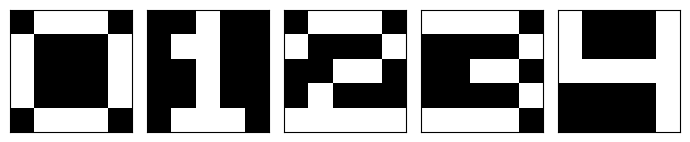

In [484]:
paint_mnist(digits)

In [ ]:
X = []
y = []



for i in range(5):
    for n in range(300):
        X.append(add_gaussian_noise(digits[i].flatten(), std=0.15))
        y.append(i)

X = np.array(X)
y = np.array(y)

In [504]:
pis = np.random.dirichlet(np.full(5, 5))

X = []
y = []



for i in range(1500):
    k = rng.choice(5, p=pis)
    X.append(add_gaussian_noise(digits[k].flatten(), std=0.15))
    y.append(k)

X = np.array(X)
y = np.array(y)

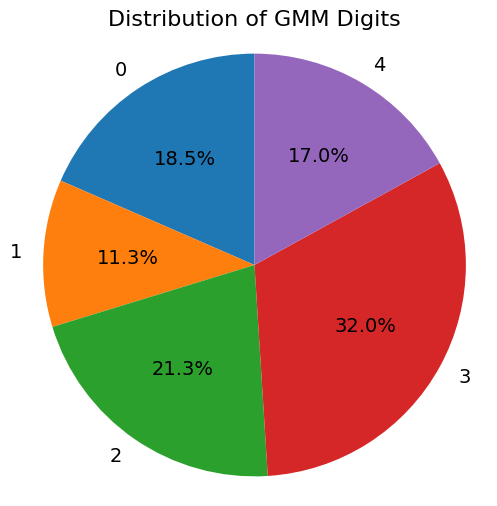

In [508]:
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=unique,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14}  # <-- Set label font size here
)
plt.title('Distribution of GMM Digits', fontsize=16)  # Optional: increase title size
plt.axis('equal')
plt.show()

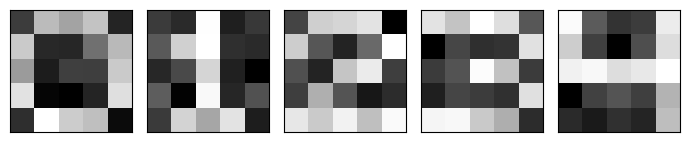

In [458]:
examples = [
    X[0].reshape(5,5),
    X[300].reshape(5,5),
    X[600].reshape(5,5),
    X[900].reshape(5,5),
    X[1200].reshape(5,5)
]

paint_mnist(examples)

In [460]:
means = []
covs = []
for k in range(5):
    means.append(np.mean(X[y==k], axis=0))
    covs.append(np.cov(X[y==k], rowvar=False))
means = np.array(means)
covs = np.array(covs)

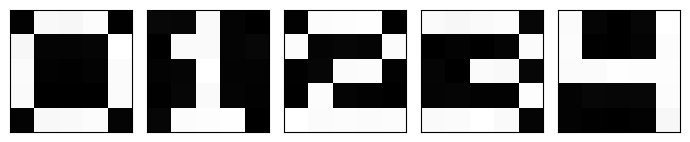

In [485]:
paint_mnist(means)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [136]:
name = "digits5x5"

np.save(f"./../Datasets/Gaussian/Processed/{name}/X_train_{name}.npy", X_train)
np.save(f"./../Datasets/Gaussian/Processed/{name}/X_test_{name}.npy", X_test)
np.save(f"./../Datasets/Gaussian/Processed/{name}/y_train_{name}.npy", y_train)
np.save(f"./../Datasets/Gaussian/Processed/{name}/y_test_{name}.npy", y_test)
np.save(f"./../Datasets/Gaussian/Processed/{name}/means_{name}.npy", means)
np.save(f"./../Datasets/Gaussian/Processed/{name}/covariances_{name}.npy", covs)

# MNAR 

In [235]:
dirpath_synthetic = "./../Datasets/Bernoulli/Processed/synthetic/"

X_train_synthetic = np.load(dirpath_synthetic + "X_train_synthetic.npy")
y_train_synthetic = np.load(dirpath_synthetic + "y_train_synthetic.npy")
X_test_synthetic = np.load(dirpath_synthetic + "X_test_synthetic.npy")
y_test_synthetic = np.load(dirpath_synthetic + "y_test_synthetic.npy")
means = np.load(dirpath_synthetic + "means_synthetic.npy")

### MNAR Missing Rate

In [236]:
rng = np.random.default_rng(5099)

In [237]:
def generate_mnar_mixture_data(X, y, K):
    N,D = X.shape
    
    γ = np.array([
            np.full((D), 0.0),np.full((D), 0.2),np.full((D), 0.4),
            np.full((D), 0.6),np.full((D), 0.8)
        ]) 

    R = np.ones((N, D), dtype=bool)  

    for n in range(N):
        k = y[n]

        R[n] = rng.binomial(1, 1 - γ[k])  

    X_missing = X.copy().astype(np.float64).copy()
    X_missing[~R] = np.nan  

    return X_missing,R
